# Market Making (RL)

*In this notebook, we will implement a simple market making strategy using reinforcement learning. The goal of the market maker is to maximize the profit by providing liquidity to the market. The market maker will place two limit orders, one buy order and one sell order, around the mid price. The market maker will adjust the price of the limit orders based on the current inventory and the recent price movements. The market maker will also adjust the size of the limit orders based on the current inventory and the recent price movements. The market maker will use reinforcement learning to learn the optimal price and size of the limit orders.*

## Setup

In [2]:
# Data loading and preprocessing
from utils.load_data import load_data
from utils.evaluate import evaluate_strategy, get_pnl

# Environment
from environment.env import Real_Data_Env

# Model
from strategies.rl import QLearning, RLStrategy, SARSA
from strategies.baselines import BestPosStrategy, StoikovStrategy


import numpy as np
import random

np.random.seed(134251)
random.seed(134251)

## Data Preparation
The data used for this notebook is the [Crypto Lake website](https://crypto-lake.com/). The data contains the order book and the trades data for the "BTC/USDT" trading pair as well as the trades on the Binance exchange. It contains 20 price levels for each order book side for each timestamp(~850k) of the day "1/10/2022" and the trades that occured on that day (~2.5M). The data is stored in a queue and the last market event is fetch to simulate a real-time market data feed.

In [3]:
market_event = load_data(max_depth = 5)
market_event_train = market_event[:1000000]
market_event_val = market_event[1000000:2000000]
market_event_test = market_event[2000000:]

del market_event

Loading book and trade data concurrently...
--------------------------------------------------
 Missing values for trades :  0
--------------------------------------------------
 Missing values for book :  0
Data loaded in 34.53s
Computing market events concurrently...
Market events computed in 15.92s


In [20]:
print(
    f"Spread: {market_event_train[39].orderbook.asks[0][0] - market_event_train[39].orderbook.bids[0][0]:.3f}$"
)
print(market_event_train[39])
print(market_event_train[40])


Spread: 1.310$
MarketEvent(exchange_ts=1664582400.032, receive_ts=1664582400.279076, orderbook=OrderBook(exchange_ts=1664582400.032, receive_ts=1664582400.279076, asks=[(19423.92, 0.0015), (19423.93, 0.11125), (19423.94, 0.13642), (19423.95, 1.11658), (19423.97, 2.12518)], bids=[(19422.61, 0.01822), (19422.6, 1.95358), (19422.41, 0.00634), (19422.38, 0.81738), (19422.37, 0.25742)]), trade=None)
MarketEvent(exchange_ts=1664582400.033, receive_ts=1664582400.279064, orderbook=None, trade=Trade(exchange_ts=1664582400.033, receive_ts=1664582400.279064, side='buy', price=19423.92, quantity=0.00131))


# Training

## Parameters

In [4]:
EXECUTION_DELAY = 1e-8
MARKET_EVENT_DELAY = 1e-6

INITIAL_CASH = 0
MIN_POSITION = -0.1  # Example: minimum position size
MAX_POSITION = 0.1  # Example: maximum position size
INTERVAL_BTW_ORDERS = 5e-2
TRADE_SIZE = 0.001
MAKER_FEE = 0  # -0.00004

## RL Model
### State space 
The state space is composed of the features study in the data preparation part. It is composed of the following features:
- Inventory ratio
$$ IR_t = \frac{Q_t - Q_{\text{min}}}{Q_{\text{max}} + Q_{\text{min}}}$$
- Books imbalance
$$\text{Book Imbalance} = \frac{\text{Total Bids} - \text{Total Asks}}{\text{Total Bids} + \text{Total Asks}}$$
- Volatility
$$\text{Return} = std(\frac{m_t - m_{t-1}}{m_{t-1}})$$
- RSI (Relative Strength Index)
$$\text{RSI} = 100 - \frac{100}{1 + \frac{\text{EMA Gain}}{\text{EMA Loss}}}$$

Each features and discretized into 10 bins. The state space is a tuple of 4 elements:



### Action space
The action space is **discrete** and is a tuple of two elements: 
- the **depth of the asks**
- the **depth of the bids**

*For instance, (1,3) means that the agent will place a sell order at the first bid price and a buy order at the third ask price.*


### Reward
The rewards *awards* the agent when he is **making profit** from either the **spread** or the **inventory**. He is *penalized* when he is **holding an order for too long** and when **the risk **associated to being exposed to variations in the mid price is too high, as well as when the agent holds more than the maximum inventory.
The reward is calculated as using (Sadighian, J. (2020). Extending deep reinforcement learning frameworks in cryptocurrency market making)
$$
    r_t = \left\{
    \begin{array}{ll}
        Q_t * (\frac{m_{t}}{m_{t-1}}-1)  + x_t^{\text{side}} * x_t^{\text{size}} * x_t^{\text{price}} - 100 ( e^{4 |\frac{Q_t - Q_{\text{min}}}{|Q_{\text{max}} - Q_{\text{min}}|} - 0.5|} -1) & \text{order executed} \\
        -\frac{\Delta t_{\text{hold}}}{\Delta t_{\text{order}}} & \text{otherwise}
    \end{array}
\right.
$$

where $Q_t$ is the inventory at time t,

$m_t$ is the mid price at time t, 

$x_t^{\text{side}}$ is the side of the order at time t, 

$x_t^{\text{size}}$ is the size of the order at time t, 

$x_t^{\text{price}}$ is the price of the order at time t


In [22]:
ALPHA = 0.9
ALPHA_DECAY = 0.9999
MIN_ALPHA = 0.01
GAMMA = 0.99
ORDER_BOOK_DEPTH = 5

NB_TRAINING = 1

### Q learning
An ensemble methods is used to reduced the variance of the Q values. The Q values are calculated as the average of the Q values of the ensemble. The Q values are updated using the following formula:

$$
Q(s_t, a_t) = Q(s_t, a_t) + \alpha * (r_t + \gamma * \max_{a} Q(s_{t+1}, a) - Q(s_t, a_t))
$$


In [41]:
QLearningTable = None

model = QLearning(
    alpha=ALPHA, 
    alpha_decay=ALPHA_DECAY,
    gamma=GAMMA,
    min_alpha=MIN_ALPHA
)
strategy = RLStrategy(
    model=model,
    min_position=MIN_POSITION,
    max_position=MAX_POSITION,
    delay=INTERVAL_BTW_ORDERS,
    trade_size=TRADE_SIZE,
    maker_fee=MAKER_FEE,
    order_book_depth=ORDER_BOOK_DEPTH,
)

# Ensemble methods to reduce the variance of the Q-table
for i in range(1,NB_TRAINING+1):
    print("Training: {}/ {}".format(i, NB_TRAINING))
    env = Real_Data_Env(market_event_train, EXECUTION_DELAY, MARKET_EVENT_DELAY)
    strategy.run(env, "train", 1500000)

    if QLearningTable is None:
        QLearningTable = model.q_table
    else:
        QLearningTable += model.q_table

    strategy.reset()

QLearningTable /= NB_TRAINING

# Save
strategy.model.q_table = QLearningTable
strategy.save_q_table("model/ensemble_Qlearning_table.npy")

Training: 1/ 1
Simulation runned for 291.18s                                                                                                                                                                           


In [ ]:
# Save
strategy.model.q_table = QLearningTable
strategy.save_q_table("model/ensemble_Qlearning_table.npy")

### SARSA
An ensemble methods is used to reduced the variance of the Q values. The Q values are calculated as the average of the Q values of the ensemble. The Q values are updated using the following formula:

$$
Q(s_t, a_t) = Q(s_t, a_t) + \alpha * (r_t + \gamma * Q(s_{t+1}, a_{t+1}))
$$

In [38]:
SARSATable = None

model = SARSA(
    alpha=ALPHA, 
    alpha_decay=ALPHA_DECAY,
    gamma=GAMMA,
    min_alpha=MIN_ALPHA
)
strategy = RLStrategy(
    model=model,
    min_position=MIN_POSITION,
    max_position=MAX_POSITION,
    delay=INTERVAL_BTW_ORDERS,
    trade_size=TRADE_SIZE,
    maker_fee=MAKER_FEE,
    order_book_depth=ORDER_BOOK_DEPTH,
)

# Ensemble methods to reduce the variance of the Q-table
for i in range(1, NB_TRAINING + 1):
    print("Training: {}/ {}".format(i, NB_TRAINING))
    env = Real_Data_Env(market_event_train, EXECUTION_DELAY, MARKET_EVENT_DELAY)
    strategy.run(env, "train", 500000)

    if SARSATable is None:
        SARSATable = model.q_table
    else:
        SARSATable += model.q_table

    strategy.reset()

SARSATable /= NB_TRAINING

# Save
strategy.model.q_table = SARSATable
strategy.save_q_table("model/ensemble_SARSA_table.npy")

Training: 1/ 1
Simulation runned for 85.89s                                                                                                                                                                            


# Validation

## Q learning

Simulation runned for 132.04s                                                                                                                                                                           
Executed Trades: 52942
Mean PnL: -0.5456


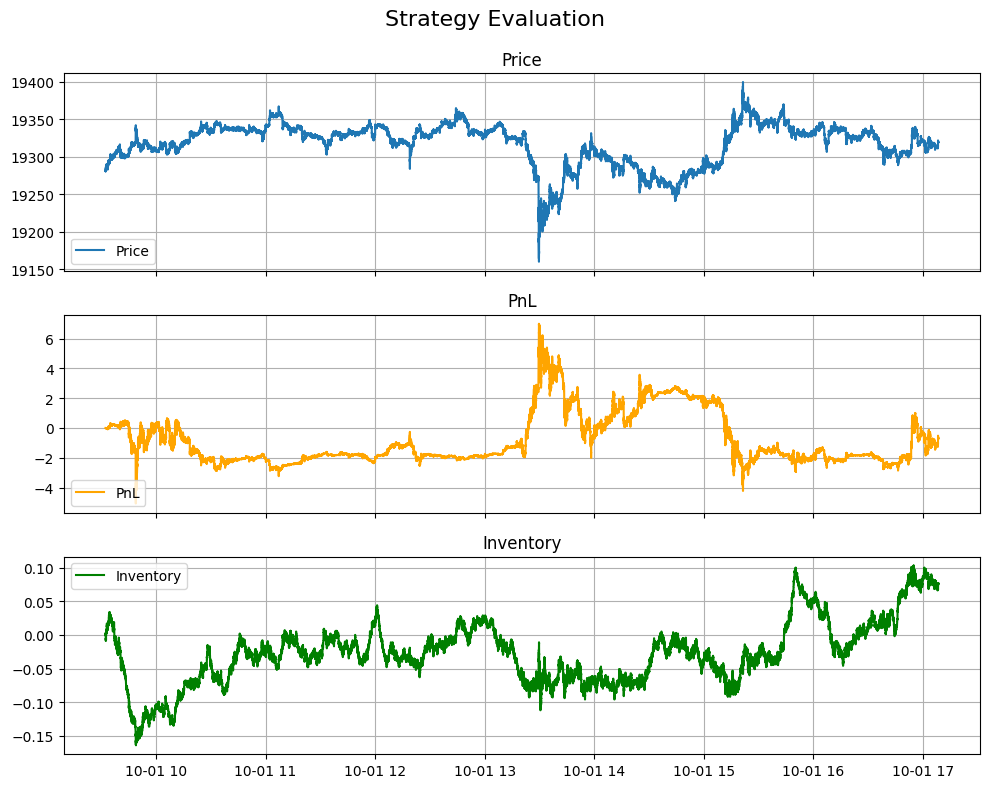

Mean Inventory: -0.0309 - Std: 0.0465 - Skew: 0.32


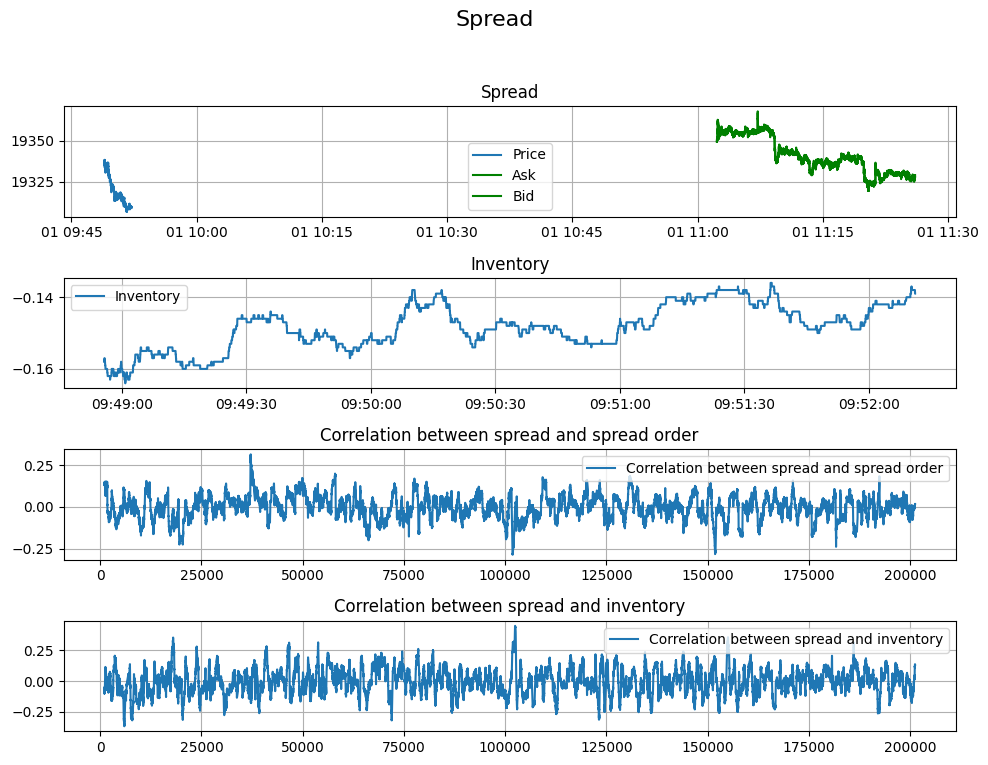

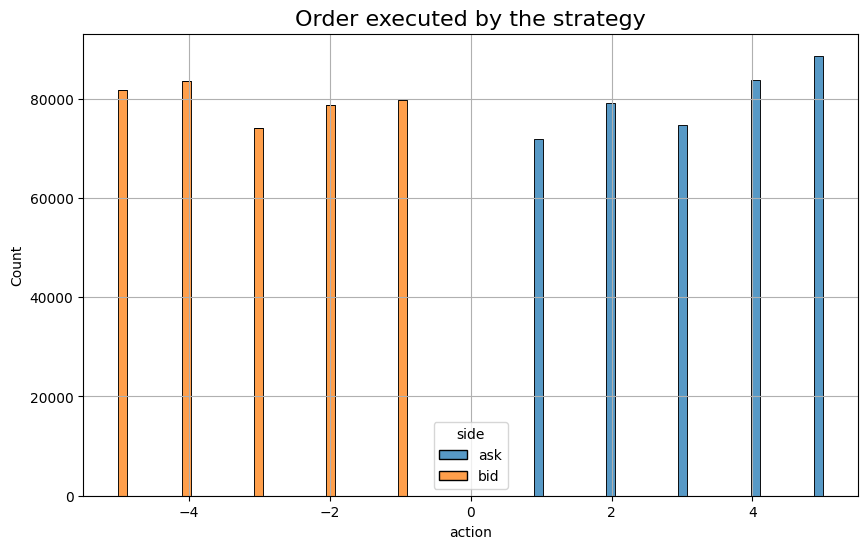

In [35]:
model = QLearning(
    alpha=MIN_ALPHA, 
    alpha_decay=ALPHA_DECAY,
    gamma=GAMMA,
    min_alpha=MIN_ALPHA
)
strategy_QL = RLStrategy(
    model=model,
    min_position=MIN_POSITION,
    max_position=MAX_POSITION,
    delay=INTERVAL_BTW_ORDERS,
    trade_size=TRADE_SIZE,
    maker_fee=MAKER_FEE,
    order_book_depth=ORDER_BOOK_DEPTH,
)
strategy_QL.load_q_table("model/ensemble_Qlearning_table.npy")
env = Real_Data_Env(market_event_val, EXECUTION_DELAY, MARKET_EVENT_DELAY)

trades, market_updates, orders, updates = strategy_QL.run(env, "test", 1500000)
evaluate_strategy(strategy_QL, trades, updates, orders)

## SARSA

Simulation runned for 264.22s                                                                                                                                                                           
Executed Trades: 50981
Mean PnL: -4.0927


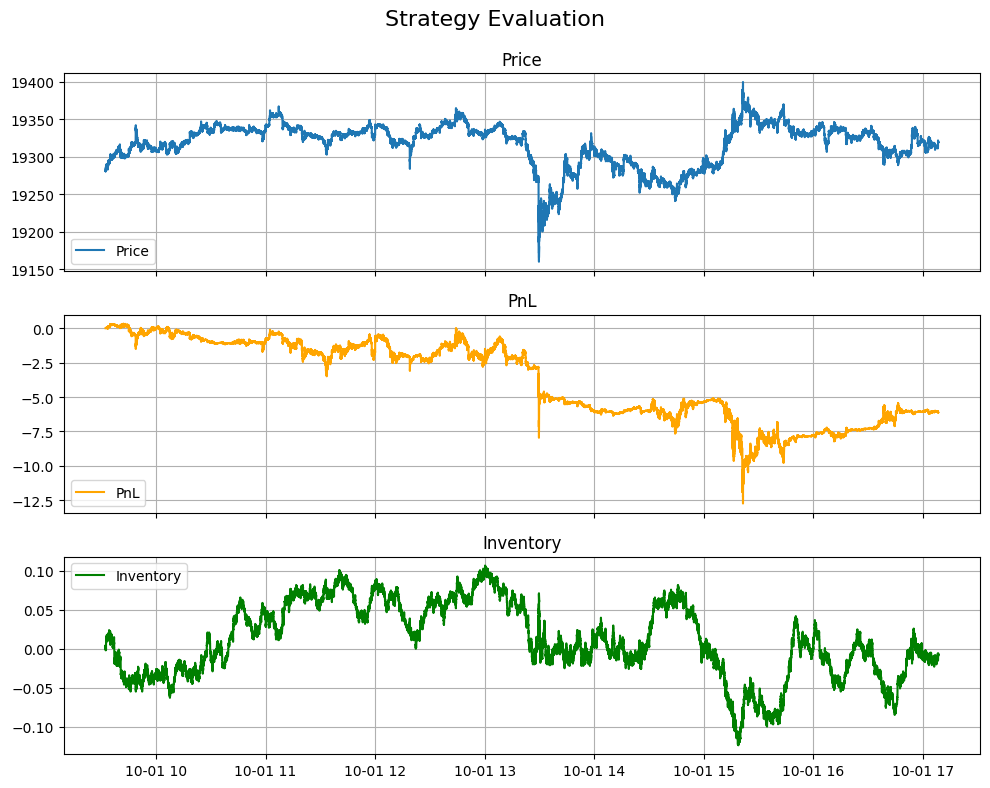

Mean Inventory: 0.0074 - Std: 0.0478 - Skew: -0.17


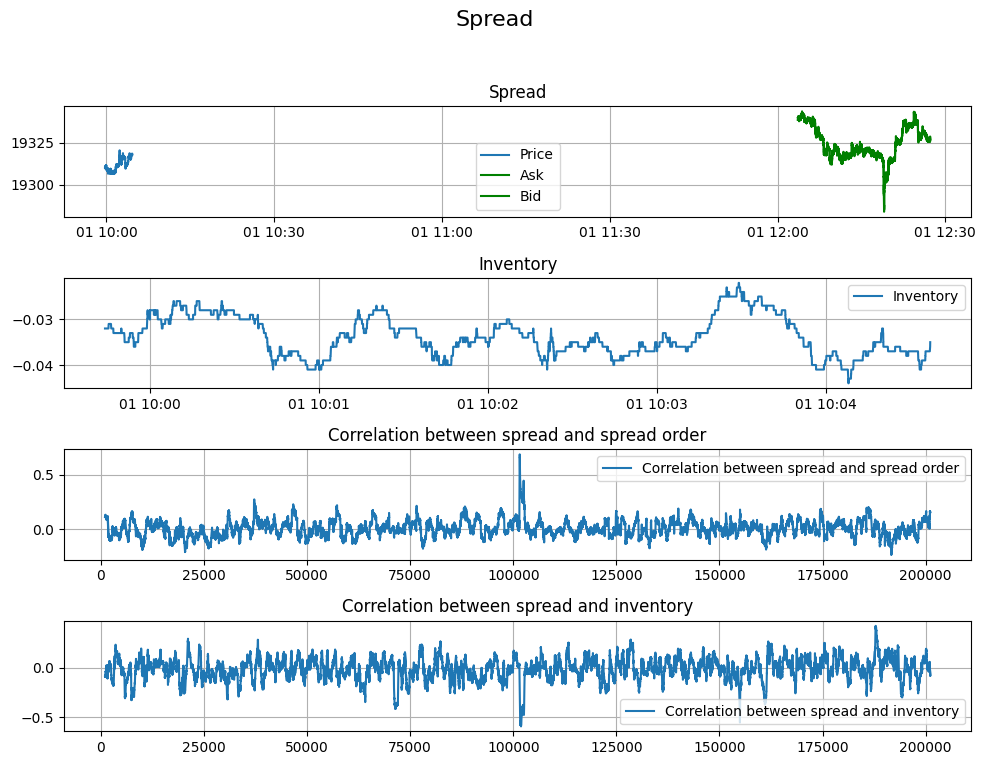

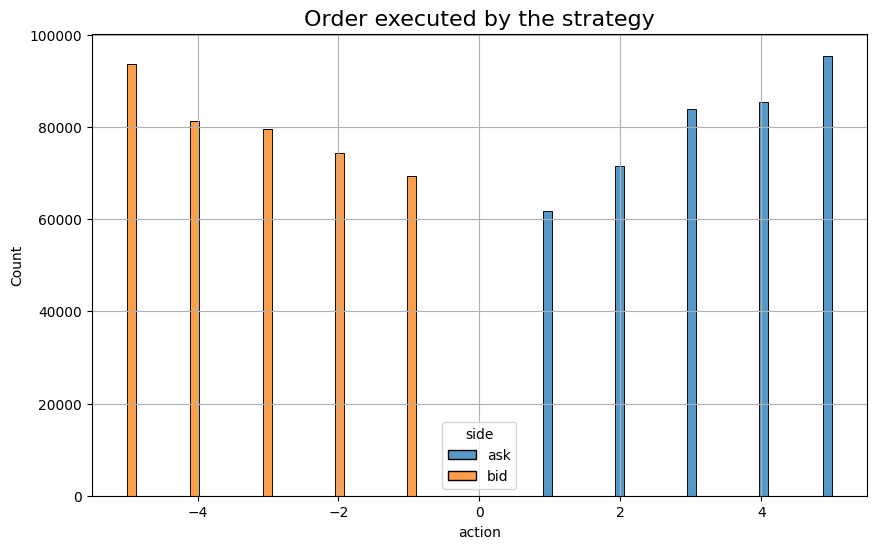

In [42]:
model = SARSA(
    alpha=MIN_ALPHA, 
    alpha_decay=ALPHA_DECAY,
    gamma=GAMMA,
    min_alpha=MIN_ALPHA
)
strategy_SARSA = RLStrategy(
    model=model,
    min_position=MIN_POSITION,
    max_position=MAX_POSITION,
    delay=INTERVAL_BTW_ORDERS,
    trade_size=TRADE_SIZE,
    maker_fee=MAKER_FEE,
    order_book_depth=ORDER_BOOK_DEPTH,
)
strategy_SARSA.load_q_table("model/ensemble_SARSA_table.npy")
env = Real_Data_Env(market_event_val, EXECUTION_DELAY, MARKET_EVENT_DELAY)

trades, market_updates, orders, updates = strategy_SARSA.run(env, "test", 1500000)
evaluate_strategy(strategy_SARSA, trades, updates, orders)

## Naive Strategy
At every moment place an order at the **best bid** and** best ask** price. When the inventory is at the limit place an order at the best bid or best ask price depending on the inventory position.

Simulation runned for 26.98s                                                                                                                                                                            


c:\Users\artco\Downloads\RL - Market Making\utils\evaluate.py:143: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.



Executed Trades: 138864
Mean PnL: 2.7466


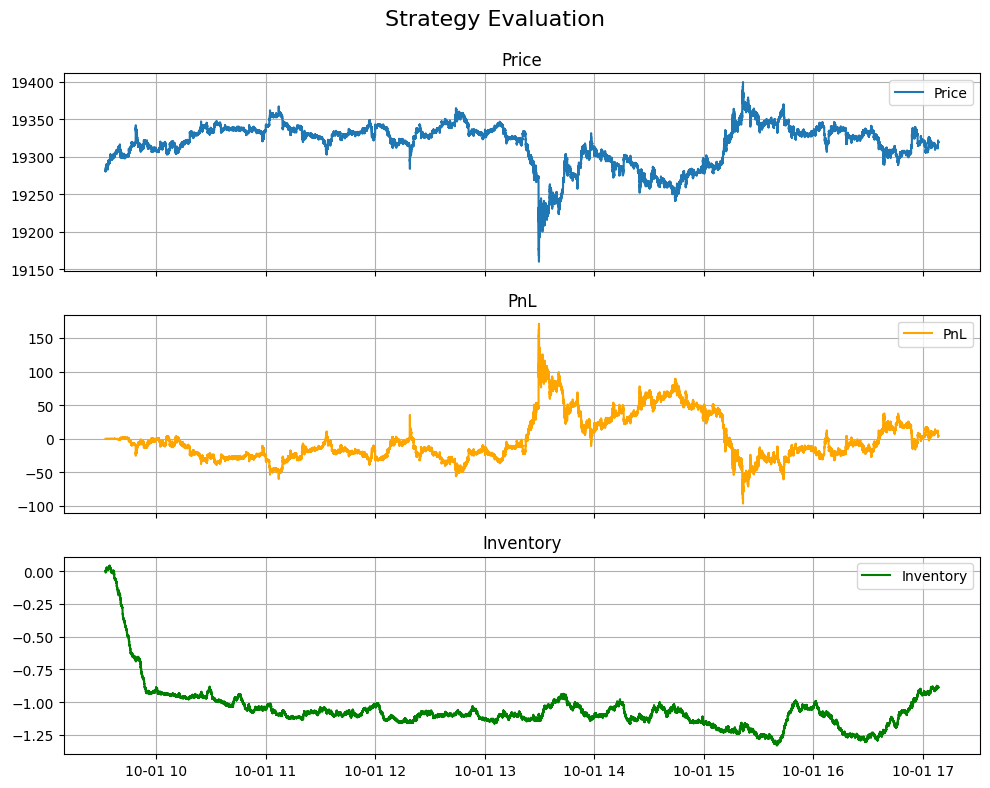

Mean Inventory: -1.0583 - Std: 0.1880 - Skew: 3.39
Trajectory not available


In [ ]:
strategyBestPos = BestPosStrategy(
    min_position=MIN_POSITION,
    max_position=MAX_POSITION,
    delay=INTERVAL_BTW_ORDERS,
    trade_size=TRADE_SIZE,
    maker_fee=MAKER_FEE,
)
env = Real_Data_Env(market_event_val, EXECUTION_DELAY, MARKET_EVENT_DELAY)

trades, market_updates, orders, updates = strategyBestPos.run(env, 1500000)
evaluate_strategy(strategyBestPos, trades, updates, orders)

## Stoikov

### Reservation Price
The reservation price $ r_t $ is given by:
$$
r_t = p_{\text{mid}} - q \cdot \gamma \cdot \sigma^2 \cdot (T - t)
$$

Where:
-  $p_{\text{mid}}$ is the current mid-price.
-  $q$  is the current inventory level.
-  $\gamma$  is a parameter representing the sensitivity to inventory.
-  $\sigma$  is the volatility of the asset.
-  $T$  is the terminal time.
-  $t$  is the current time.

### Optimal Spread
The optimal spread $s_t$ is given by:
$$
s_t = \frac{\theta \cdot \sigma^2 \cdot (T - t) + 2 \ln \left( 1 + \frac{\theta}{k} \right)}{2}
$$

Where:
- $ \theta$  is a risk aversion parameter.
- $ \sigma$  is the volatility of the asset.
- $ T $ is the terminal time.
- $ t $ is the current time.
- $ k $ is a parameter related to the order arrival rate.



Executed Trades: 7828
Mean PnL: 0.2111


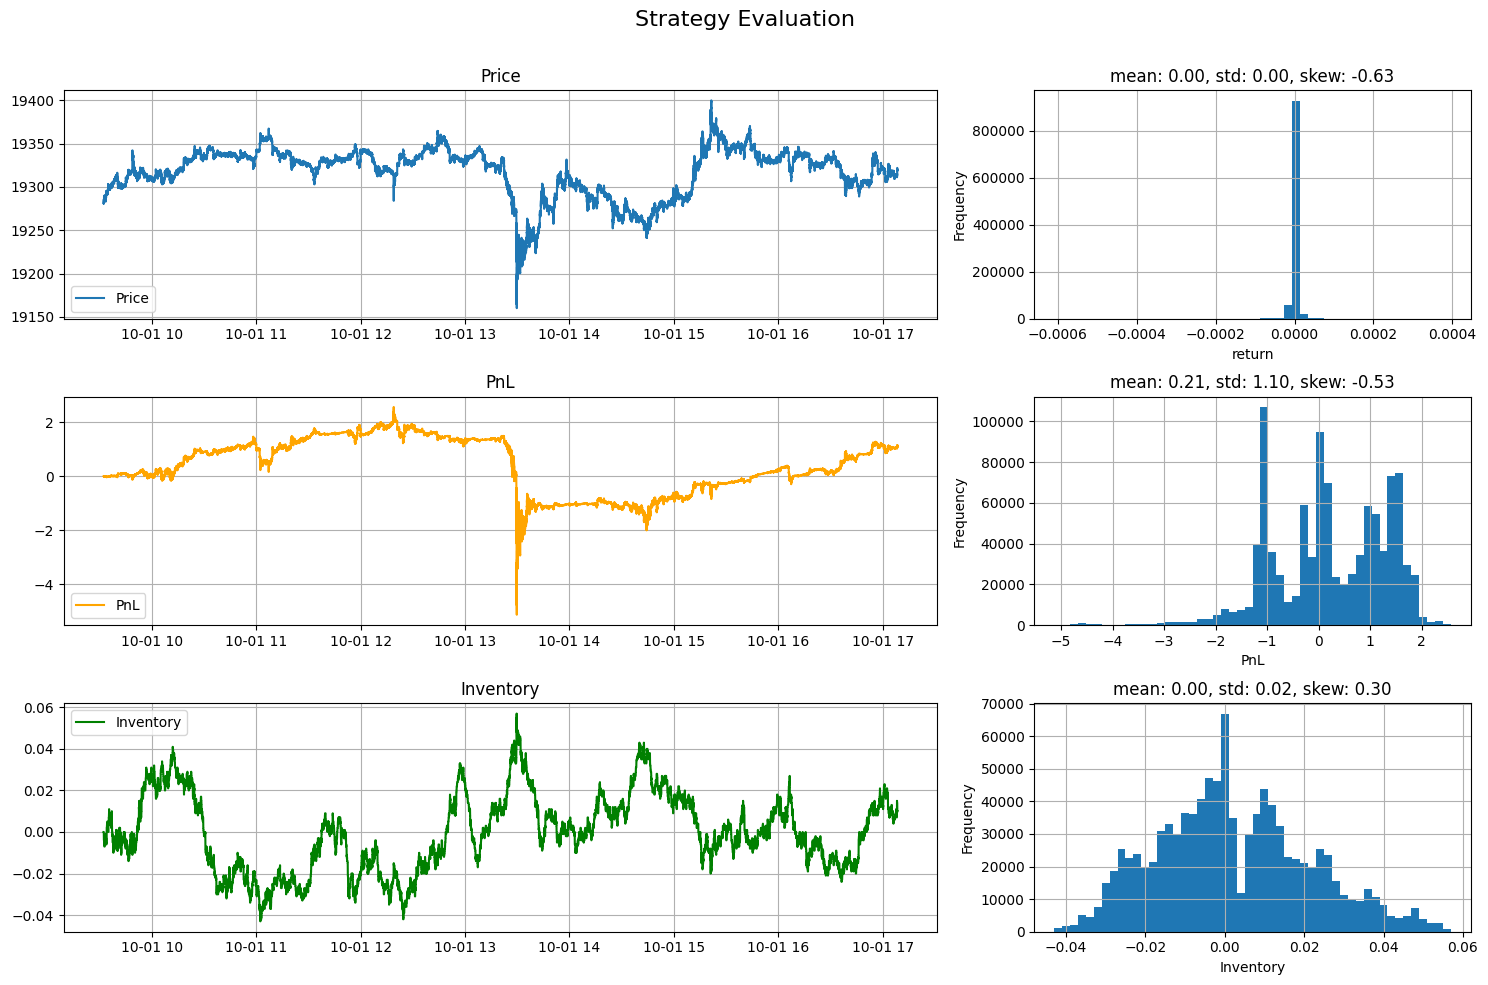

MemoryError: Unable to allocate 396. MiB for an array with shape (103, 504036) and data type float64

In [7]:
strategyStoikov = StoikovStrategy(
    delay=INTERVAL_BTW_ORDERS,
    trade_size=TRADE_SIZE,
    maker_fee=MAKER_FEE,
)
env = Real_Data_Env(market_event_val, EXECUTION_DELAY, MARKET_EVENT_DELAY)

trades, market_updates, orders, updates = strategyStoikov.run(env, 1500000)
evaluate_strategy(strategyStoikov, trades, updates, orders)